<a href="https://colab.research.google.com/github/ParsaHejabi/ComputationalIntelligence-ComputerAssignments/blob/main/HW1/COVID19_Iran_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 infections in Iran - Linear Regression

## Download global data from WHO website
Data is available at [WHO Coronavirus Disease (COVID-19) Dashboard](https://covid19.who.int/)

Downloading data using `wget`

In [ ]:
!wget https://covid19.who.int/WHO-COVID-19-global-data.csv

--2020-10-16 18:26:46--  https://covid19.who.int/WHO-COVID-19-global-data.csv
Resolving covid19.who.int (covid19.who.int)... 13.224.0.115, 13.224.0.29, 13.224.0.109, ...
Connecting to covid19.who.int (covid19.who.int)|13.224.0.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2853359 (2.7M) [text/csv]
Saving to: ‘WHO-COVID-19-global-data.csv’

WHO-COVID-19-global 100%[===================>]   2.72M  --.-KB/s    in 0.05s   

2020-10-16 18:26:46 (55.1 MB/s) - ‘WHO-COVID-19-global-data.csv’ saved [2853359/2853359]



## Import all the libraries


*   numpy
*   pandas
*   matplotlib



In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Modifying raw dataset


*   Parse `Date_reported` as `np.datetime64`
*   Dropping ` Country_code` and ` WHO_region` columns



In [ ]:
raw_dataset = pd.read_csv('WHO-COVID-19-global-data.csv')

dataset = raw_dataset.copy()
dataset = dataset.drop(columns=[' Country_code', ' WHO_region', ' Cumulative_cases', ' New_deaths', ' Cumulative_deaths', 'Date_reported'])
dataset = dataset.dropna()
dataset.head()

,Country,New_cases
0,Afghanistan,0
1,Afghanistan,0
2,Afghanistan,0
3,Afghanistan,0
4,Afghanistan,0


## Filtering raw dataset to Iran country only

In [ ]:
dataset_iran = dataset.copy()
dataset_iran.drop(dataset_iran[dataset_iran[' Country'] != 'Iran (Islamic Republic of)'].index, inplace=True)
dataset_iran.drop(columns=[' Country'], inplace=True)
dataset_iran.rename(columns={" New_cases": "New_cases"}, inplace=True)
dataset_iran.reset_index(inplace=True, drop=True)
dataset_iran.reset_index(inplace=True)
dataset_iran.head()

,index,New_cases
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## Plotting the data related to Iran

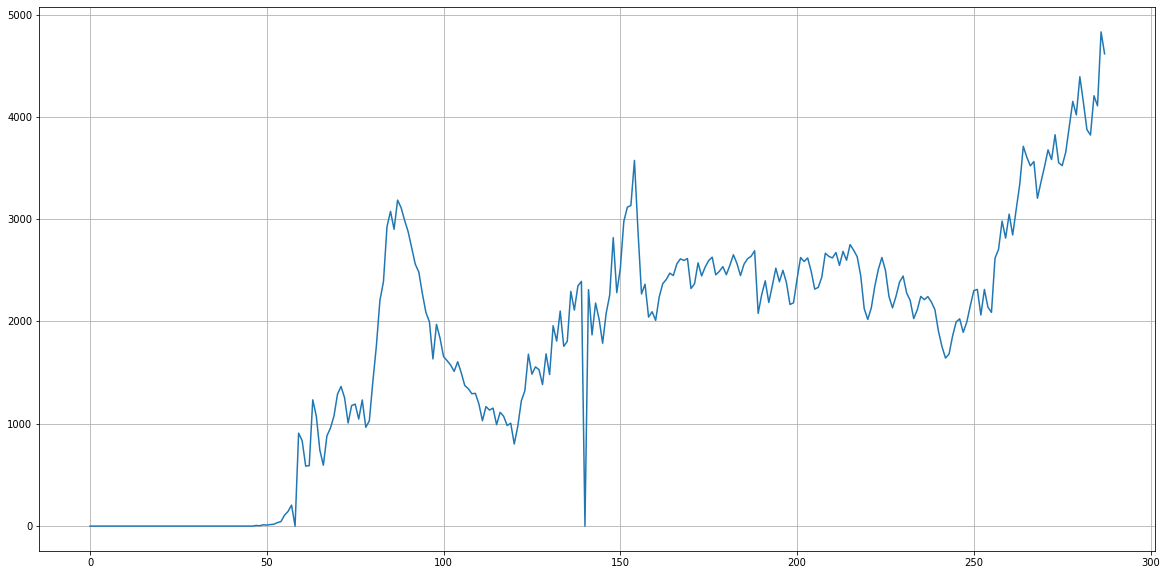

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(dataset_iran['index'], dataset_iran['New_cases'])
ax.grid(True)

plt.show()

## Making train and dataset

In [ ]:
train_dataset_iran = dataset_iran.sample(frac=0.8, random_state=0, axis=0)
train_dataset_iran.sort_index(inplace=True)
test_dataset_iran = dataset_iran.drop(train_dataset_iran.index)
print ("Number of training examples: " + str(train_dataset_iran.shape[0]))
print ("Number of testing examples: " + str(test_dataset_iran.shape[0]))
print ("train_dataset_iran shape: " + str(train_dataset_iran.shape))
print ("test_dataset_iran shape: " + str(test_dataset_iran.shape))

Number of training examples: 230
Number of testing examples: 58
train_dataset_iran shape: (230, 2)
test_dataset_iran shape: (58, 2)


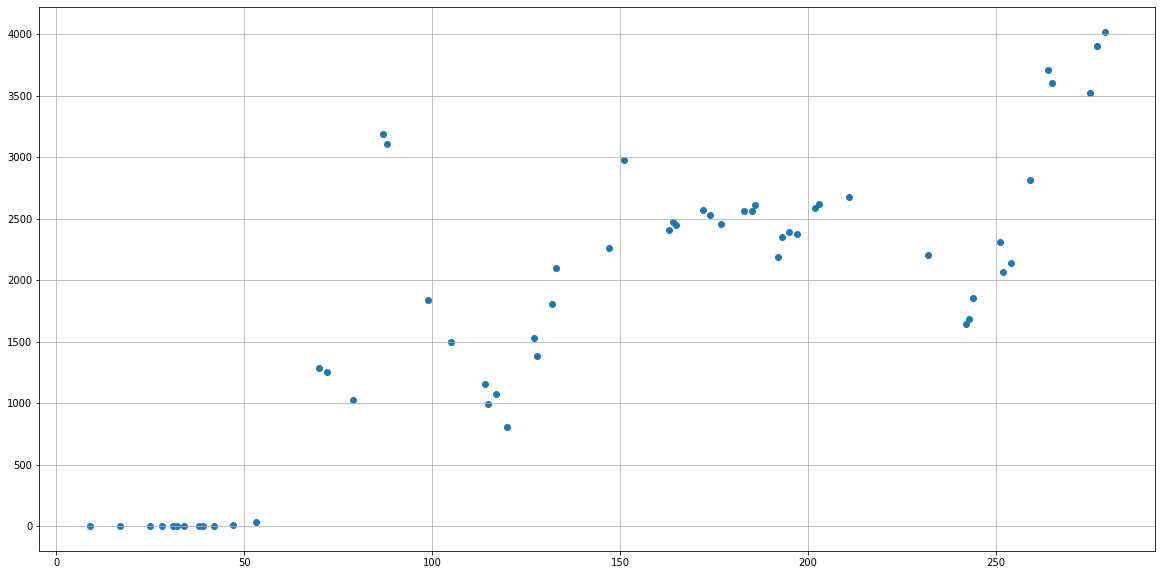

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(test_dataset_iran['index'], test_dataset_iran['New_cases'])
ax.grid(True)

plt.show()

## Split features from labels

In [ ]:
train_dataset_iran_y = pd.DataFrame(train_dataset_iran.pop('New_cases'))
test_dataset_iran_y = pd.DataFrame(test_dataset_iran.pop('New_cases'))

In [ ]:
train_dataset_iran_stats = train_dataset_iran.describe().transpose()
train_dataset_iran_stats

,count,mean,std,min,25%,50%,75%,max
index,230.0,142.391304,83.940788,0.0,69.5,141.5,216.75,287.0


In [ ]:
def norm(x):
  return (x - train_dataset_iran_stats['mean']) / train_dataset_iran_stats['std']
  
normed_train_dataset_iran = norm(train_dataset_iran)
normed_test_dataset_iran = norm(test_dataset_iran)

In [ ]:
normed_train_dataset_iran.head()

,index
0,-1.696330
1,-1.684417
2,-1.672504
3,-1.660591
4,-1.648678


In [ ]:
normed_test_dataset_iran.head()

,index
9,-1.589112
17,-1.493807
25,-1.398501
28,-1.362762
31,-1.327022


In [ ]:
print ("Number of training examples: " + str(normed_train_dataset_iran.shape[0]))
print ("Number of testing examples: " + str(normed_test_dataset_iran.shape[0]))
print ("train_dataset_iran shape: " + str(normed_train_dataset_iran.shape))
print ("test_dataset_iran shape: " + str(normed_test_dataset_iran.shape))

print ("Number of training labels: " + str(train_dataset_iran_y.shape[0]))
print ("Number of testing labels: " + str(test_dataset_iran_y.shape[0]))
print ("train_dataset_iran_y shape: " + str(train_dataset_iran_y.shape))
print ("test_dataset_iran_y shape: " + str(test_dataset_iran_y.shape))

Number of training examples: 230
Number of testing examples: 58
train_dataset_iran shape: (230, 1)
test_dataset_iran shape: (58, 1)
Number of training labels: 230
Number of testing labels: 58
train_dataset_iran_y shape: (230, 1)
test_dataset_iran_y shape: (58, 1)


In [ ]:
def initialize_params():
  w = 0
  b = 0
    
  return w, b

In [ ]:
def propagate(w, b, x, y):
  m = x.shape[0]

  A = w * x + b
  cost = (1 / (2. * m)) * np.sum((A.values - y) ** 2)

  dw = (1 / m) * np.squeeze(np.dot((A.values - y).T, x)[0])
  db = np.squeeze((1 / m) * np.sum(A.values - y))

  cost = np.squeeze(cost)
  assert(cost.shape == ())
    
  grads = {"dw": dw, "db": db}
  
  return grads, cost

In [ ]:
def optimize(w, b, x, y, num_iterations, learning_rate, print_cost = False):
  costs = []
  
  for i in range(num_iterations):
    grads, cost = propagate(w, b, x, y)
    
    dw = grads["dw"]
    db = grads["db"]
    
    w = w - learning_rate * dw
    b = b - learning_rate * db
    
    if i % 100 == 0:
      costs.append(cost)
    
    if print_cost and i % 100 == 0:
      print ("Cost after iteration %i: %f" %(i, cost))
    
  params = {"w": w, "b": b}
    
  grads = {"dw": dw, "db": db}
    
  return params, grads, costs

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
  w, b = initialize_params()
  
  parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
  
  w = parameters["w"]
  b = parameters["b"]
  
  Y_prediction_test = w * X_test + b
  Y_prediction_train = w * X_train + b
  
  print("train error: {} %".format(np.mean((Y_prediction_train.values - Y_train) ** 2)))
  print("test error: {} %".format(np.mean((Y_prediction_test.values - Y_test) ** 2)))
  
  d = {"costs": costs,
       "Y_prediction_test": Y_prediction_test, 
       "Y_prediction_train" : Y_prediction_train, 
       "w" : w, 
       "b" : b,
       "learning_rate" : learning_rate,
       "num_iterations": num_iterations}
  
  return d

In [ ]:
d = model(normed_train_dataset_iran, train_dataset_iran_y, normed_test_dataset_iran, test_dataset_iran_y, num_iterations = 5000, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 2301464.689130
Cost after iteration 100: 465444.775958
Cost after iteration 200: 218937.319903
Cost after iteration 300: 185840.303161
Cost after iteration 400: 181396.510529
Cost after iteration 500: 180799.853320
Cost after iteration 600: 180719.740467
Cost after iteration 700: 180708.983601
Cost after iteration 800: 180707.539241
Cost after iteration 900: 180707.345299
Cost after iteration 1000: 180707.319257
Cost after iteration 1100: 180707.315760
Cost after iteration 1200: 180707.315291
Cost after iteration 1300: 180707.315228
Cost after iteration 1400: 180707.315219
Cost after iteration 1500: 180707.315218
Cost after iteration 1600: 180707.315218
Cost after iteration 1700: 180707.315218
Cost after iteration 1800: 180707.315218
Cost after iteration 1900: 180707.315218
Cost after iteration 2000: 180707.315218
Cost after iteration 2100: 180707.315218
Cost after iteration 2200: 180707.315218
Cost after iteration 2300: 180707.315218
Cost after iteration 2400: 

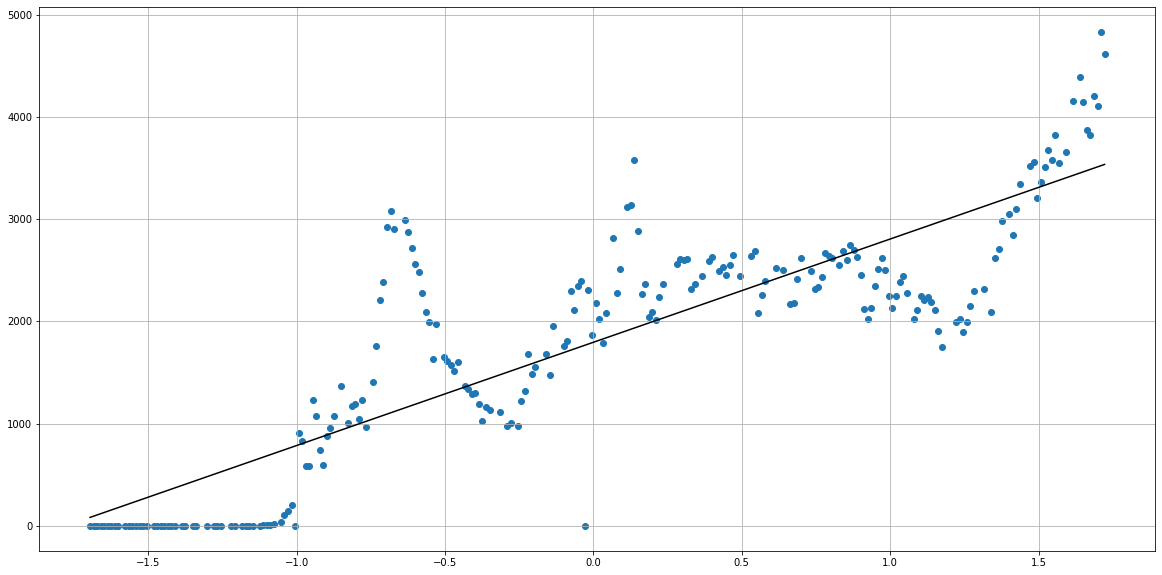

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(normed_train_dataset_iran['index'], train_dataset_iran_y['New_cases'])
ax.plot(normed_train_dataset_iran['index'], d['w'] * normed_train_dataset_iran['index'] + d['b'], color='black')
ax.grid(True)

plt.show()